In [60]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scipy

In [3]:
df = pd.read_csv("../data/Training Data_Case 3.csv", index_col=0)
returns = df.pct_change().dropna()

In [4]:
# Define the number of assets in the portfolio
n_assets = len(df.columns)

# Define the minimum and maximum weight of each asset in the portfolio
min_weight = 0.0
max_weight = 1.0

# Define the target return and the desired risk level of the portfolio
target_return = 0.1
desired_risk = 0.2

# Define the risk tolerance parameter (affects the weighting of the risk parity allocation)
risk_tolerance = 1.0

# Define the objective function to minimize
def objective(weights):
    # Calculate the portfolio returns and variance
    portfolio_return = np.dot(weights, returns.mean()) 
    portfolio_covariance = np.cov(returns.T) 
    portfolio_variance = np.dot(weights.T, np.dot(portfolio_covariance, weights))

    # Calculate the skew and kurtosis of the returns distribution
    skewness = np.sum((returns.mean() - portfolio_return)**3) / (n_assets * portfolio_variance**(3/2))
    kurtosis = np.sum((returns.mean() - portfolio_return)**4) / (n_assets * portfolio_variance**2) - 3

    # Calculate the contribution of each asset to the risk parity allocation
    asset_risk_contributions = np.sqrt(np.diag(portfolio_covariance)) * weights / np.sqrt(portfolio_variance)
    asset_risk_contributions /= np.sum(asset_risk_contributions)

    # Calculate the objective function value
    obj = (portfolio_return - target_return)**2 + risk_tolerance * np.sum((asset_risk_contributions - 1/n_assets)**2)
    obj += skewness**2 + kurtosis**2

    return obj

# Define the initial guess for the weights of each asset in the portfolio
init_guess = np.ones(n_assets) / n_assets

# Define the weight constraints for the optimization
weight_constraints = [{'type': 'ineq', 'fun': lambda x: x[i] - min_weight} for i in range(n_assets)]
weight_constraints += [{'type': 'ineq', 'fun': lambda x: -x[i] + max_weight} for i in range(n_assets)]
weight_constraints += [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]

# Perform the optimization
result = minimize(objective, init_guess, constraints=weight_constraints)

# Calculate the portfolio returns, variance, and Sharpe Ratio
portfolio_return = np.dot(result.x, returns.mean(axis=0)) 
portfolio_covariance = np.cov(returns.T) 
portfolio_variance = np.dot(result.x.T, np.dot(portfolio_covariance, result.x))
sharpe_ratio = (252 ** 0.5) * (portfolio_return) / np.sqrt(portfolio_variance)

# Print the optimized portfolio weights and Sharpe Ratio
print("Optimized Portfolio Weights: ", result.x)
print("Sharpe Ratio: ", sharpe_ratio)


Optimized Portfolio Weights:  [0.10210583 0.1302953  0.14138723 0.09678279 0.09904126 0.06973882
 0.0899162  0.06236273 0.12945536 0.07891449]
Sharpe Ratio:  1.05524736920883


In [5]:
# define the returns of the 10 assets as a numpy array
returns = np.array(returns)

# calculate the mean returns and covariance matrix of the assets
mean_returns = np.mean(returns, axis=0)
cov_matrix = np.cov(returns.T)

# calculate the skewness and kurtosis of the returns
skewness = np.array([scipy.stats.skew(ret) for ret in returns.T])
kurtosis = np.array([scipy.stats.kurtosis(ret) for ret in returns.T])

# define the objective function to be minimized
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, skewness, kurtosis):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return / portfolio_std_dev) * np.power(1 + skewness @ weights + 0.5 * kurtosis @ np.square(weights), 1/3)
    return -sharpe_ratio

# set the initial weight allocation to be equal for all assets
num_assets = len(df.columns)
weights_0 = np.array([1/num_assets]*num_assets)

# define the constraints for the optimization
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# define the bounds for the optimization (between 0 and 1 for each weight)
bounds = tuple((0,1) for _ in range(num_assets))

# minimize the negative Sharpe ratio to find the optimal weights
result = minimize(negative_sharpe_ratio, weights_0, args=(mean_returns, cov_matrix, skewness, kurtosis), method='SLSQP', bounds=bounds, constraints=constraints)

# calculate the Sharpe ratio for the optimal weights
optimal_weights = result.x
optimal_return = np.dot(optimal_weights, mean_returns)
optimal_std_dev = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
sharpe_ratio = np.sqrt(252) * optimal_return / optimal_std_dev

# print the optimal weights and Sharpe ratio
print("Optimal weights:")
print(optimal_weights)
print("Sharpe ratio: {:.2f}".format(sharpe_ratio))


Optimal weights:
[1.47606498e-17 2.43745824e-01 2.49850526e-01 2.34825064e-01
 8.14671052e-18 1.12877464e-17 1.01355236e-18 1.18286347e-01
 1.53292238e-01 0.00000000e+00]
Sharpe ratio: 1.45


In [56]:
class MaximizeSharpeModel:
    def __init__(self, historical_prices):
        self.historical_prices = historical_prices
        self.num_assets = len(self.historical_prices.columns)
        
        self.returns = np.array(self.historical_prices.pct_change().dropna())
        self.mean_returns = np.mean(self.returns, axis=0)
        self.cov_matrix = np.cov(self.returns.T)
        
        self.skewness = np.array([scipy.stats.skew(ret) for ret in self.returns.T])
        self.kurtosis = np.array([scipy.stats.kurtosis(ret) for ret in self.returns.T])
        
        self.sharpe_ratio = None
        self.weights = self._optimize_weights()
        
    def _negative_sharpe_ratio(self, weights, mean_returns, cov_matrix, skewness, kurtosis):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        a = 1 + skewness @ weights + 0.5 * kurtosis @ np.square(weights)
        sharpe_ratio = (portfolio_return / portfolio_std_dev) * np.power(np.sign(a) * np.abs(a), 1/3)
        return -sharpe_ratio
    
    def _optimize_weights(self):
        # set the initial weight allocation to be equal for all assets
        weights_0 = np.array([1/self.num_assets]*self.num_assets)

        # define the constraints for the optimization
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        # define the bounds for the optimization (between 0 and 1 for each weight)
        bounds = tuple((0,1) for _ in range(self.num_assets))

        # minimize the negative Sharpe ratio to find the optimal weights
        result = minimize(self._negative_sharpe_ratio, weights_0, args=(self.mean_returns, self.cov_matrix, self.skewness, self.kurtosis), method='SLSQP', bounds=bounds, constraints=constraints)

        # calculate the Sharpe ratio for the optimal weights
        optimal_weights = result.x
        optimal_return = np.dot(optimal_weights, mean_returns)
        optimal_std_dev = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
        self.sharpe_ratio = np.sqrt(252) * optimal_return / optimal_std_dev
        
        return result.x
    
    def append_prices(self, current_prices):
        self.returns = np.append(self.returns, (current_prices / self.historical_prices.iloc[-1]) - 1, axis=0)
    
    def update_weights(self):
        self.mean_returns = np.mean(self.returns, axis=0)
        self.cov_matrix = np.cov(self.returns.T)
        
        self.skewness = np.array([scipy.stats.skew(ret) for ret in self.returns.T])
        self.kurtosis = np.array([scipy.stats.kurtosis(ret) for ret in self.returns.T])
        self.weights = self._optimize_weights()
        
        

In [58]:
model = MaximizeSharpeModel(df[:3])

sharpe_ratios = []
for i in range(3,len(df)):
    model.append_prices(df[i:i+1])
    if i % 100 == 0:
        model.update_weights()
        sharpe_ratios.append(model.sharpe_ratio)


C:\Users\redce\AppData\Local\Temp\ipykernel_26440\22647908.py:21: RuntimeWarning: invalid value encountered in power
  sharpe_ratio = (portfolio_return / portfolio_std_dev) * np.power(np.sign(a) * np.abs(a), 1/3)


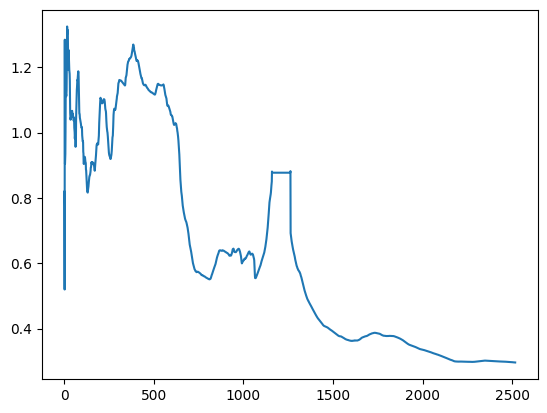

In [61]:
plt.plot(sharpe_ratios)